In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt


from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow.keras
import tensorflow as tf
import cv2

from sklearn.metrics import jaccard_score
from tensorflow.keras.datasets import mnist

Loading the data

In [2]:
# functions

def loadNumpyArray(filename):
    return np.load(filename+'.npy')

def jaccardSimilarity(mask1,mask2):
    return jaccard_score(mask1.ravel(),mask2.ravel())

In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('Loading the data from 1.3')
composite_images_trainX=loadNumpyArray('q4dataset_composite_imgs_train')
composite_images_testX = loadNumpyArray('q4dataset_composite_imgs_test')

train_X = composite_images_trainX
test_X = composite_images_testX

print('Showing some stats for the data..')
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

# print('Loading the data from 1.1')
# binary_masks_trainX = loadNumpyArray('q2dataset_train')
# binary_masks_testX = loadNumpyArray('q2dataset_test')

Loading the data from 1.3
Showing some stats for the data..
X_train: (5000, 56, 56, 12)
Y_train: (60000,)
X_test:  (1000, 56, 56, 12)
Y_test:  (10000,)


Preparing the data

In [4]:
# Set some parameters
IMG_WIDTH = 56
IMG_HEIGHT = 56
IMG_CHANNELS = 1
OUTPUT_CHANNELS = 11
MODEL_NAME = 'modelq4.h5'

seed = 42
random.seed = seed
np.random.seed = seed

print("Preparing the data")

no_of_samples = train_X.shape[0]
X_train = np.zeros((no_of_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((no_of_samples, IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=np.bool)
print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
# print('Getting and resizing train images and masks ... ')

for i in range(no_of_samples):
    X_train[i,:,:,0] = train_X[i,:,:,0]
    Y_train[i,:,:,:] = train_X[i,:,:,1:]

# test data
test_samples_no = test_X.shape[0]
X_test = np.zeros((test_samples_no, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((test_samples_no, IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=np.bool)

sizes_test = []

for i in range(test_samples_no):
    X_test[i,:,:,0] = test_X[i,:,:,0]
    Y_test[i,:,:,:] = test_X[i,:,:,1:]

print('Done!')

Preparing the data
X_train (5000, 56, 56, 1)
Y_train (5000, 56, 56, 11)
Done!


Defining the model

In [5]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

# c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
# c3 = Dropout(0.2) (c3)
# c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
# p3 = MaxPooling2D((2, 2)) (c3)

# c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
# c4 = Dropout(0.2) (c4)
# c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
# p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
# u6 = concatenate([u6, c4])
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
# c6 = Dropout(0.2) (c6)
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

# u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
# u7 = concatenate([u7, c3])
# c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
# c7 = Dropout(0.2) (c7)
# c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(11, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 56, 56, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 56, 56, 16)   160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 56, 56, 16)   0           conv2d[0][0]                     
______________________________________________________________________________________________

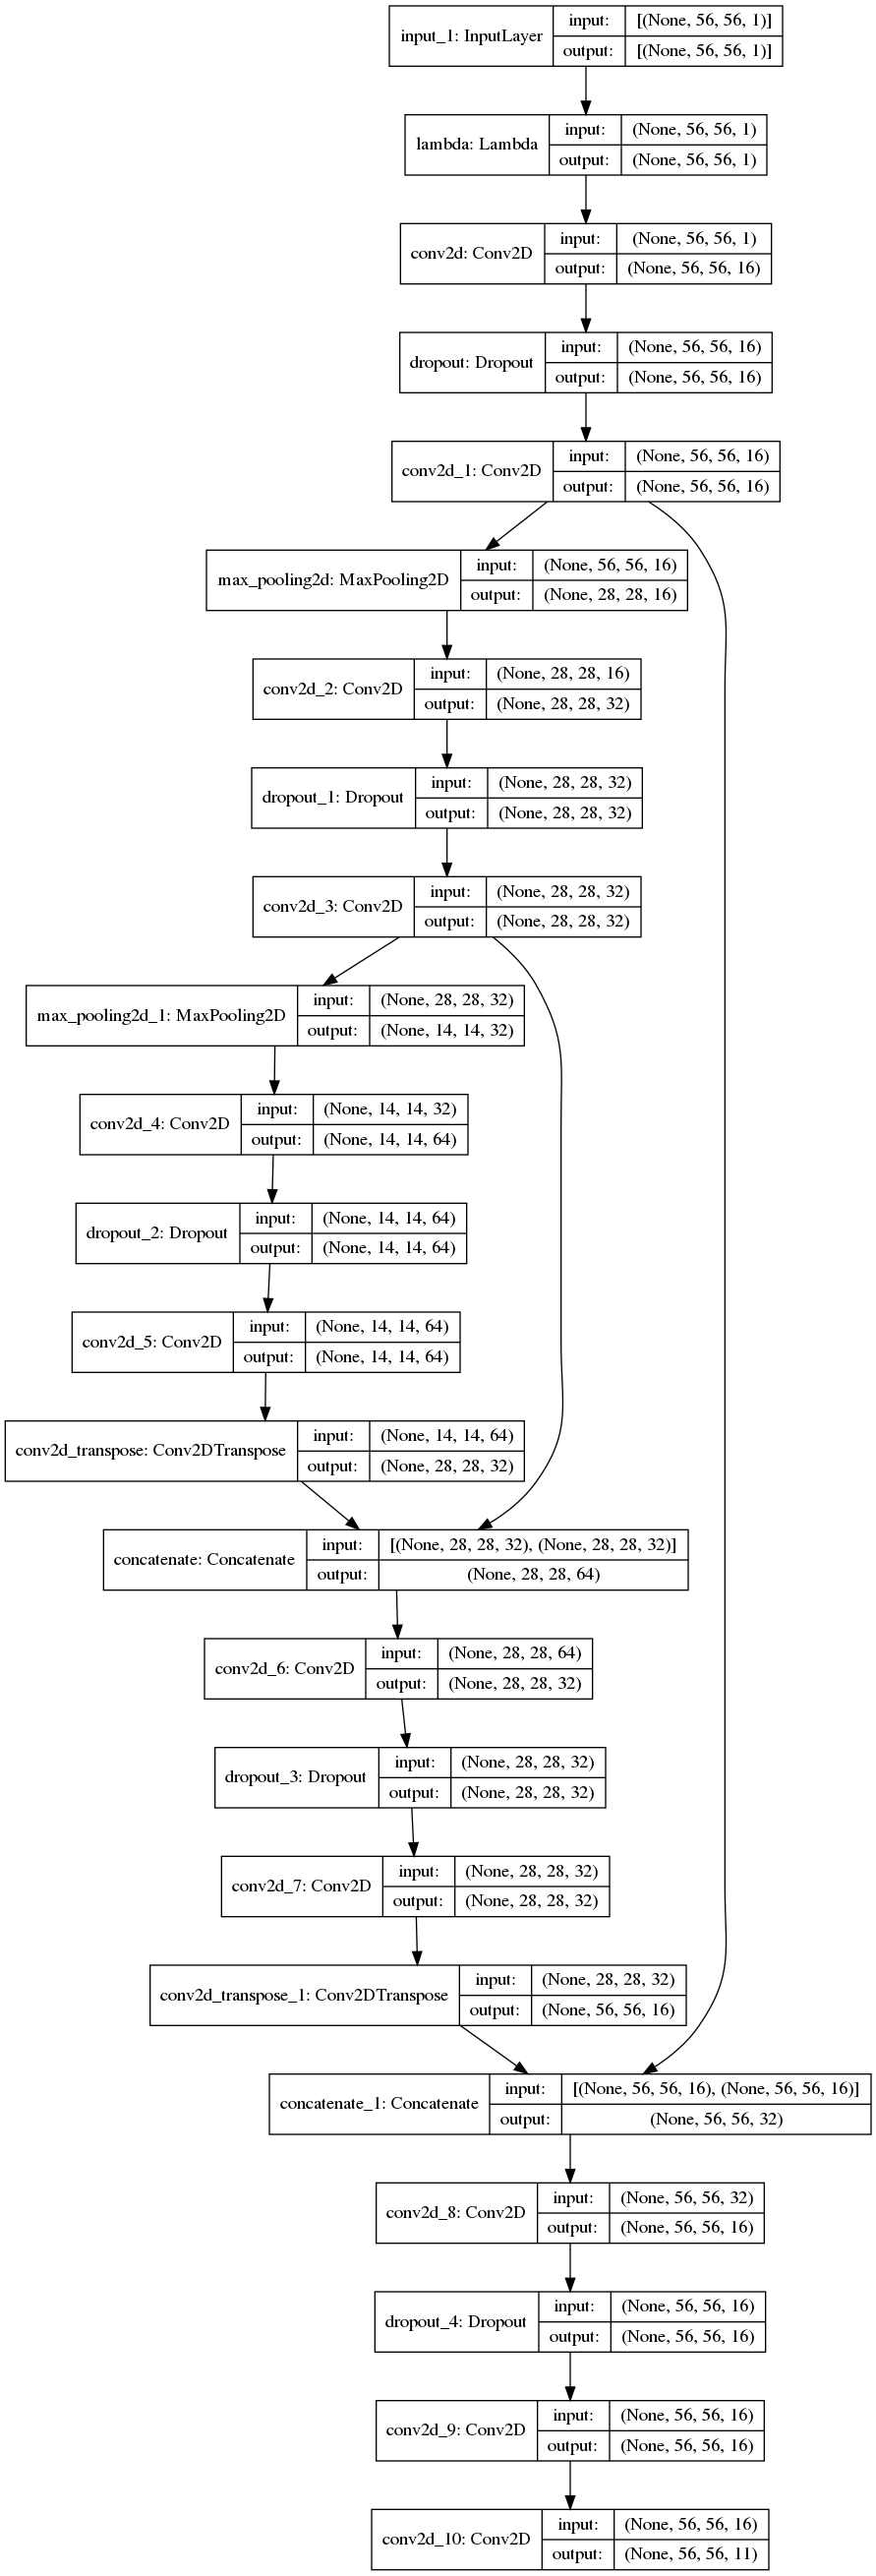

In [6]:
tf.keras.utils.plot_model(
    model, to_file='q4model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

Training the model

In [7]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(MODEL_NAME, verbose=1, save_best_only=True)
epochs =  10
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=epochs,callbacks=[earlystopper, checkpointer])


Epoch 1/10
282/282 [==============================] - 69s 239ms/step - loss: 0.1514 - acc: 0.7902 - val_loss: 0.0443 - val_acc: 0.8827

Epoch 00001: val_loss improved from inf to 0.04429, saving model to modelq4.h5
Epoch 2/10
282/282 [==============================] - 62s 220ms/step - loss: 0.0433 - acc: 0.8857 - val_loss: 0.0341 - val_acc: 0.9110

Epoch 00002: val_loss improved from 0.04429 to 0.03408, saving model to modelq4.h5
Epoch 3/10
282/282 [==============================] - 63s 223ms/step - loss: 0.0333 - acc: 0.9155 - val_loss: 0.0234 - val_acc: 0.9524

Epoch 00003: val_loss improved from 0.03408 to 0.02335, saving model to modelq4.h5
Epoch 4/10
282/282 [==============================] - 63s 222ms/step - loss: 0.0230 - acc: 0.9522 - val_loss: 0.0115 - val_acc: 0.9838

Epoch 00004: val_loss improved from 0.02335 to 0.01152, saving model to modelq4.h5
Epoch 5/10
282/282 [==============================] - 63s 223ms/step - loss: 0.0142 - acc: 0.9765 - val_loss: 0.0073 - val_acc: 

Testing the model

In [8]:
model = load_model(MODEL_NAME)
preds_test = model.predict(X_test, verbose=1)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)

32/32 [==============================] - 3s 79ms/step


In [9]:
size0,sizex,sizey,sizechannels = preds_test.shape

binary_preds_test = np.zeros(preds_test.shape)

total_jac_index = 0


for k in range(size0):
    for i in range(sizex):
        for j in range(sizey):
            max_index=np.argmax(preds_test[k,i,j,:])
            binary_preds_test[k,i,j,max_index]=1


for k in range(size0):
    jac_index = 0
    count=0
    for ch in range(sizechannels):
        if np.sum(np.sum(Y_test[k,:,:,ch]))!=0 and np.sum(np.sum(binary_preds_test[k,:,:,ch]))!=0: 
            count+=1
            jac_index+= jaccardSimilarity(binary_preds_test[k,:,:,ch],Y_test[k,:,:,ch])
    jac_index = jac_index/count
    total_jac_index += jac_index

total_jac_index = total_jac_index/size0 
        
    
            
# for k in range(size0):
#     union_count = np.zeros(sizechannels)
#     intersection_count = np.zeros(sizechannels)
#     for i in range(sizex):
#         for j in range(sizey):
#             max_index=np.argmax(preds_test[k,i,j,:])
#             if Y_test[k,i,j,max_index]==1:
#                 union_count[max_index] +=1
#                 intersection_count[max_index] +=1
#             else:
#                 union_count[max_index] +=1
#                 union_count[Y_test[k,i,j,:]==1] +=1
    
#     # calc jac index
#     jac_index = 0
#     deno=0
#     for index in range(union_count.size):
#         if union_count[index]!=0:
#             deno+=1
#             jac_index += intersection_count[index] / union_count[index]
#     jac_index = jac_index/deno
#     total_jac_index +=jac_index

# total_jac_index = total_jac_index/size0

print('Shape of predicted test samples are ',preds_test.shape)
print('No of samples in test set are ',size0)
print('Jaccard index is coming out to be ',total_jac_index)
            
    

Shape of predicted test samples are  (1000, 56, 56, 11)
No of samples in test set are  1000
Jaccard index is coming out to be  0.9712379303272716


In [12]:
from matplotlib import pyplot

def setMatRange(mat):
    max_value = np.max(mat)
    mat = mat / max_value * 255
    return mat

def plotFewCompositeSamples(samples,filename,index):
    for i in range(9):	
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(setMatRange(samples[i,:,:,index]), cmap=pyplot.get_cmap('gray'))
    pyplot.savefig(filename)
    pyplot.show()

plotFewCompositeSamples(binary_preds_test,'q4testpred.png',-1)
plotFewCompositeSamples(Y_test,'q4testtrue.png',-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


# Thank You!